## Install and imports

In [ ]:
import tensorflow as tf

assert tf.test.is_gpu_available()

In [ ]:
!pip -q install lucid>=0.2.3

In [ ]:
import os
import io
import sys
from string import Template

import numpy as np
import PIL.Image
import matplotlib.pylab as pl

from IPython.display import clear_output, display, Image, HTML

from lucid.misc.gl.glcontext import create_opengl_context
import OpenGL.GL as gl

from lucid.misc.gl import meshutil
from lucid.misc.gl import glrenderer
import lucid.misc.io.showing as show
from lucid.misc.io import load
from lucid.misc.tfutil import create_session

from lucid.modelzoo import vision_models
from lucid.optvis import objectives
from lucid.optvis import param
from lucid.optvis import render as lucid_render
from lucid.optvis.param.spatial import sample_bilinear

In [ ]:
create_opengl_context()
gl.glGetString(gl.GL_VERSION)

b'4.5.0 NVIDIA 384.111'

## Loading 3D model



In [ ]:
!gsutil cp gs://deepdream/article_models.zip . && \
 unzip -qo article_models.zip && \
 cat article_models/readme.txt

Copying gs://deepdream/article_models.zip...
- [1 files][ 12.9 MiB/ 12.9 MiB]
Operation completed over 1 objects/12.9 MiB.
Model sources:

bunny http://alice.loria.fr/index.php/software/7-data/37-unwrapped-meshes.html
skull https://sketchfab.com/models/1a9db900738d44298b0bc59f68123393
horse https://sketchfab.com/models/864497a206024c8e832b5127e9e23f2f
david https://sketchfab.com/models/3a8f65d7db8e4ba7a0ea886e2b636128


In [ ]:
!ls article_models

bunny.mtl  bunny.png  david.mtl  horse.jpg  horse.obj	skull.jpg  skull.obj
bunny.obj  david.jpg  david.obj  horse.mtl  readme.txt	skull.mtl


In [ ]:
mesh = meshutil.load_obj('article_models/bunny.obj')
mesh = meshutil.normalize_mesh(mesh)
original_texture = load('article_models/bunny.png')


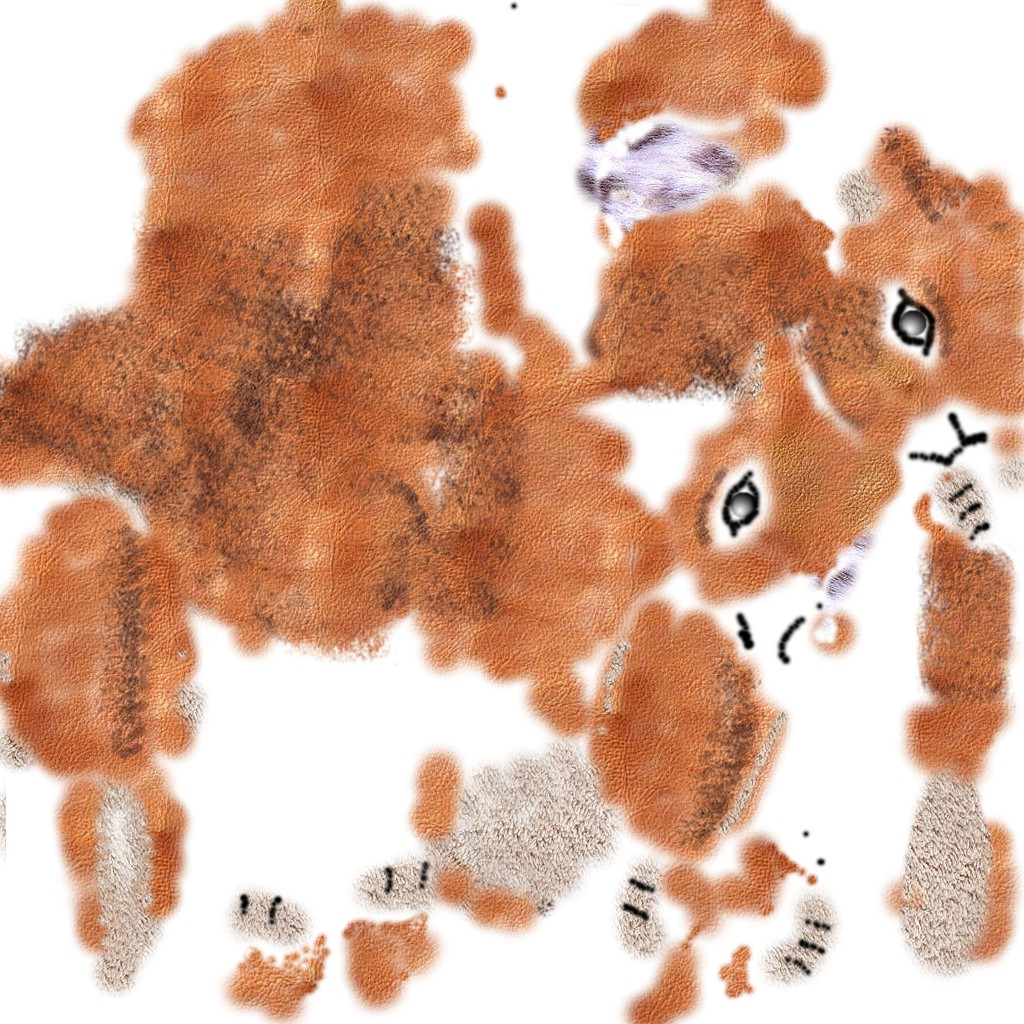

In [ ]:
show.textured_mesh(mesh, original_texture)

### Renderer

In [ ]:
random_view = meshutil.sample_view(11.0, 13.0,)

In [ ]:
renderer = glrenderer.MeshRenderer((512, 512))


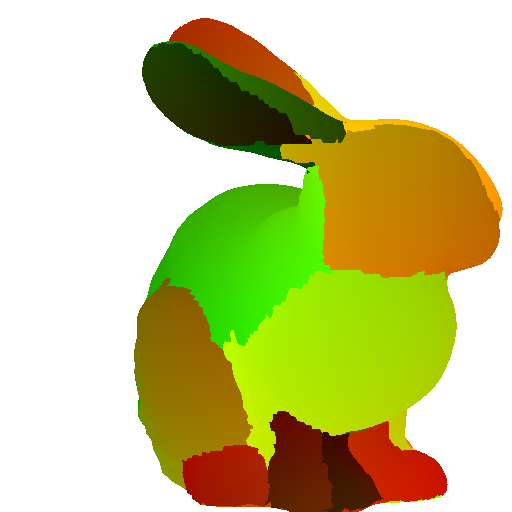

In [ ]:
random_view_image = renderer.render_mesh(modelview=random_view, **mesh)
show.image(random_view_image)

In [ ]:
model = vision_models.InceptionV1()
model.load_graphdef()


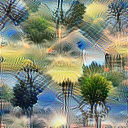

In [ ]:
objective = objectives.channel('mixed4b_pool_reduce_pre_relu', 17)
vis = lucid_render.render_vis(model, objective, verbose=False) # (lucid.optvis.render is imported as lucid_render to differentiate it from the 3D renderer)
show.image(vis)

### Synthesize the texture

In [ ]:
sess = create_session()

# t_fragments is used to feed rasterized UV coordinates for the current view.
# Channels: [U, V, _, Alpha]. Alpha is 1 for pixels covered by the object, and
# 0 for background.
t_fragments = tf.placeholder(tf.float32, [None, None, 4])
t_uv = t_fragments[...,:2]
t_alpha = t_fragments[...,3:]

t_texture = param.image(1024, fft=True, decorrelate=True)[0]
t_frame = sample_bilinear(t_texture, t_uv) * t_alpha

model.import_graph(t_frame)


def T(layer):
  return sess.graph.get_tensor_by_name("import/%s:0"%layer)

# obj = objectives.channel('mixed3a_1x1_pre_relu', 1)(T)
# obj = objectives.channel('mixed4a_1x1_pre_relu', 26)(T)
# obj = objectives.channel('mixed4a_1x1_pre_relu', 11)(T)
# obj = objectives.channel('mixed4a_3x3_pre_relu', 27)(T)
# obj = objectives.channel('mixed4a_3x3_pre_relu', 174)(T)
# obj = objectives.channel('mixed4a_1x1_pre_relu', 179)(T)
# obj = objectives.channel('mixed4a_1x1_pre_relu', 190)(T)
# obj = objectives.channel('mixed4a_1x1_pre_relu', 5)(T)

obj = objectives.channel('mixed4b_pool_reduce_pre_relu', 17)(T)
tf.losses.add_loss(-obj)


t_lr = tf.constant(0.01)
t_loss = tf.losses.get_total_loss()
trainer = tf.train.AdamOptimizer(t_lr)
train_op = trainer.minimize(t_loss)

init_op = tf.global_variables_initializer()
init_op.run()



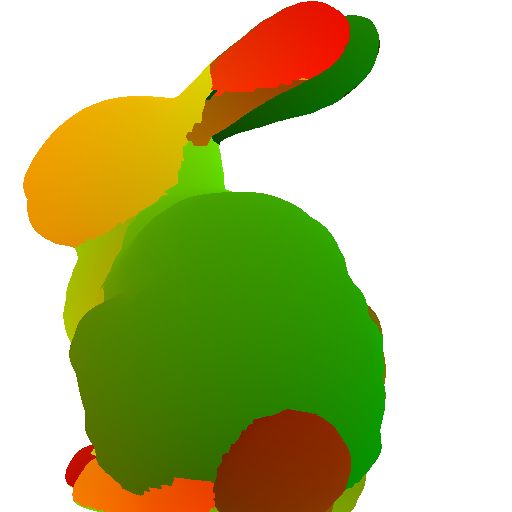
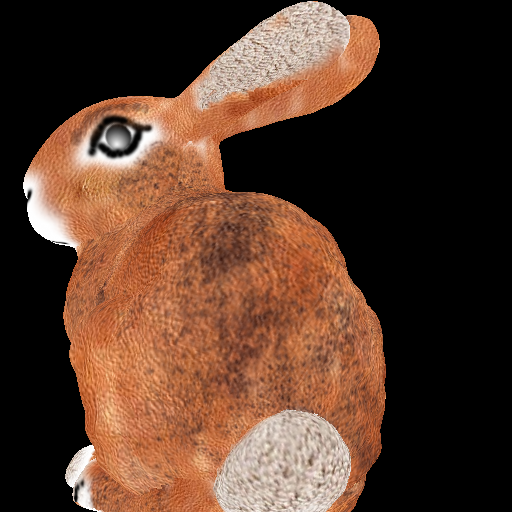

In [ ]:
fragments = renderer.render_mesh(modelview=meshutil.sample_view(11.0, 13.0), **mesh)
img = t_frame.eval({t_fragments: fragments, t_texture: original_texture})
show.images([fragments, img])


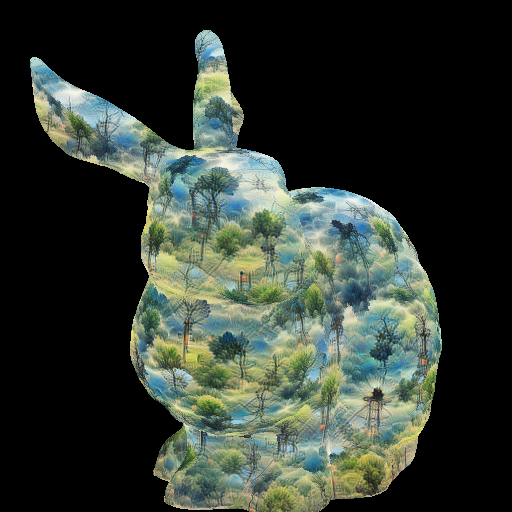
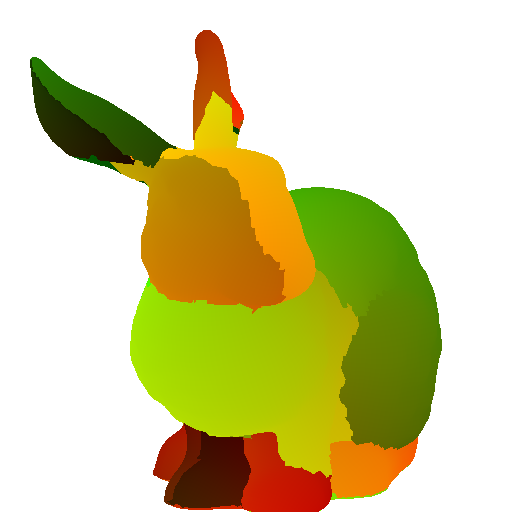

400 -352.8991


In [ ]:
loss_log = []
init_op.run()

for i in range(400):
  
  # Render mesh UVs with OpenGL
  fragments = renderer.render_mesh(modelview=meshutil.sample_view(11.0, 13.0), **mesh)
  
  # Perform step optimization for the current view
  _, loss = sess.run([train_op, t_loss], {t_fragments: fragments, t_lr:0.03})
  loss_log.append(loss)
  
  # Reporting
  if i==0 or (i+1)%50 == 0:
    clear_output()
    last_frame = sess.run(t_frame, {t_fragments: fragments})
    show.images([last_frame, fragments], ['current', 'uv'])
    
  if i==0 or (i+1)%10 == 0:
    print(len(loss_log), loss)


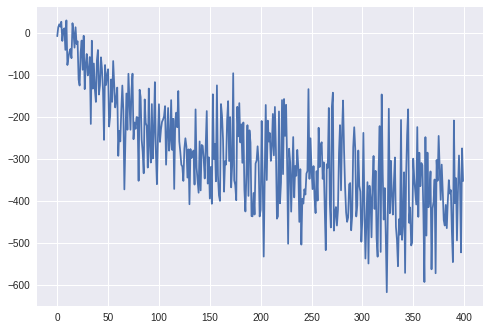

In [ ]:
pl.plot(loss_log);

### View the result


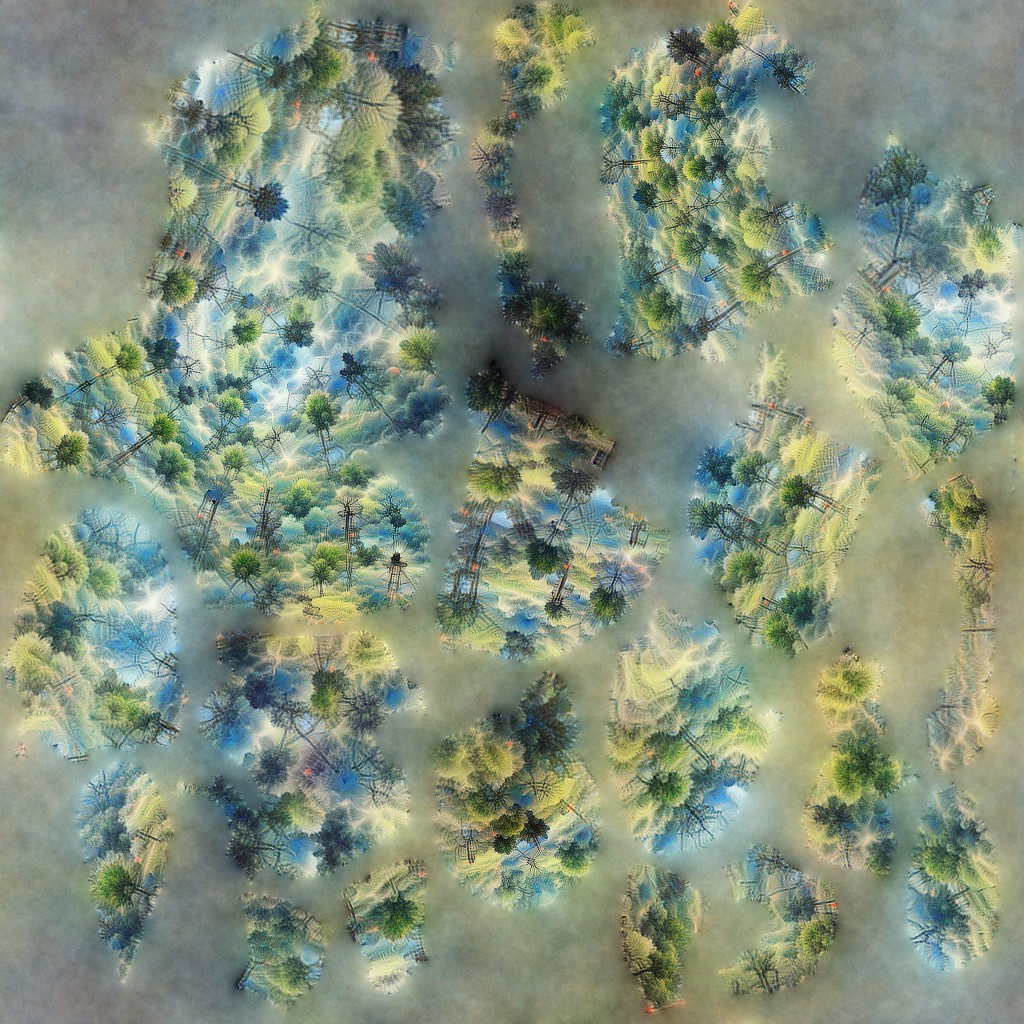

In [ ]:
texture = t_texture.eval()
show.textured_mesh(mesh, texture)


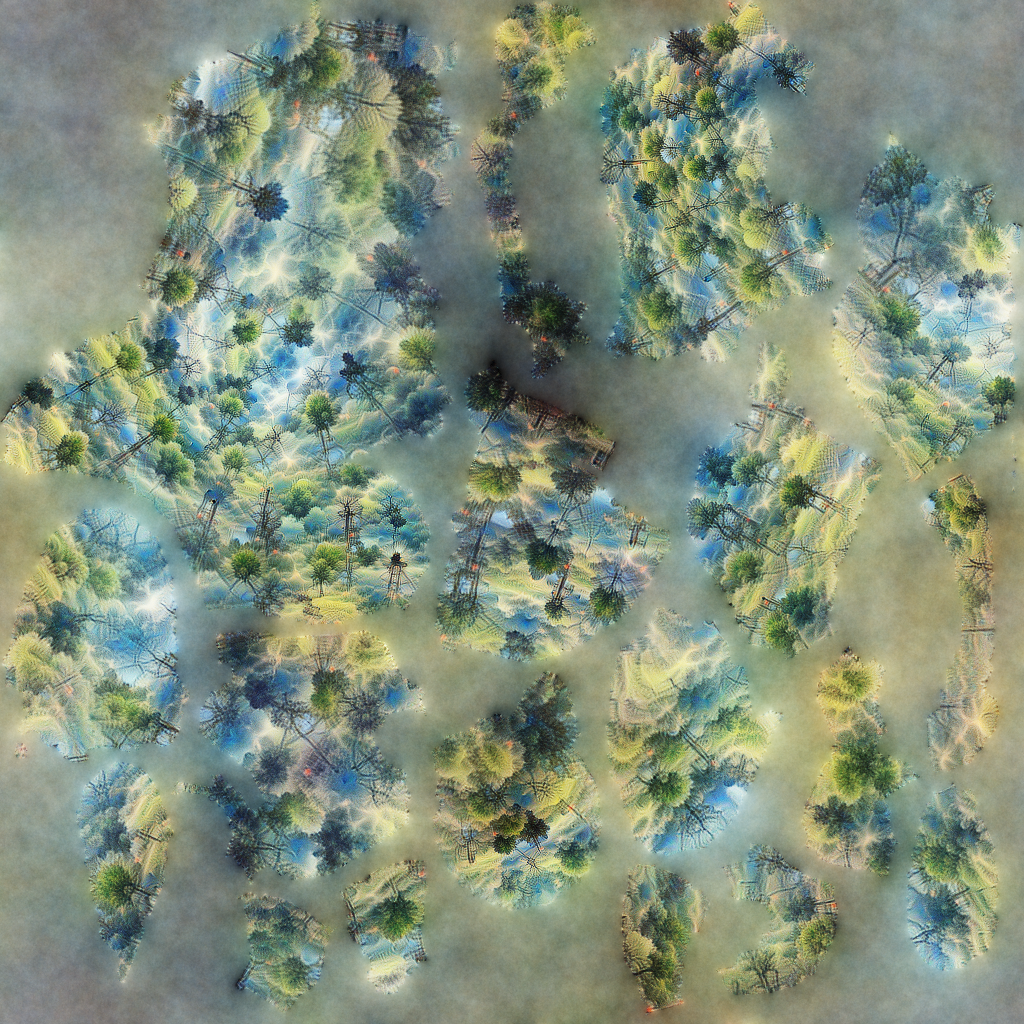

In [ ]:
show.image(texture, 'jpeg')